In [2]:
'''
Author:         Shafkat Ibrahimy
Last Update:    3/10/24
Email:          shafkat.ibrahimy@gmail.com
'''

'\nAuthor:         Shafkat Ibrahimy\nLast Update:    3/10/24\nEmail:          shafkat.ibrahimy@gmail.com   \n'

## Turbine Wake Analytics Project: Predicting Power Loss Using Neural Networks

### 0. Libraries & Functions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

# set a random seed for consistency/reproducibility 
np.random.seed(20)

# CNN model (1 D) - Convolutional Neural Network
def create_cnn_model(X_train_cnn, filters1=32, kernel_size1=3, filters2=64, kernel_size2=3, units=128, num_layers=3, num_conv_layers=4):
    '''
    Creates a convolutional neural network given hyperparameters and returns the model. 
    Number of convolutional and hidden layers can be specified
    '''
    # creates container for NN layers
    model = Sequential()
    # create convolutional layers
    for _ in range(num_conv_layers):
        model.add(Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu', padding='same', input_shape=(X_train_cnn.shape[1], 1)))
        # create pooling layer
        model.add(MaxPooling1D(pool_size=1))
    # creates flatten layer
    model.add(Flatten())
    # creates hidden layers
    for _ in range(num_layers):
        model.add(Dense(units, activation='relu'))
    # create output layer
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# LSTM model - Long Short-Term Memory
def create_lstm_model(X_train_lstm, units=128, num_layers=1, num_lstm_layers=2):
    '''
    Creates a LSTM neural network given hyperparameters and returns the model. 
    Number of LSTM and hidden layers can be specified
    '''
    # creates a container for NN layers
    model = Sequential()
    # create LSTM layers
    for _ in range(num_lstm_layers):
        model.add(LSTM(units, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
    # creates flatten layer
    model.add(Flatten())
     # creates hidden layers
    for _ in range(num_layers):
        model.add(Dense(units, activation='tanh'))
    # create output layer
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Deep ANN model (Artificial Neural Network)
def create_deep_model(X_train, y_train, neurons=80, num_layers=3, epoch=400, activ='relu'):
    '''
    Creates a Deep neural network given hyperparameters and returns the model. 
    Number of hidden layers can be specified.
    '''
    # creates a container for NN layers
    model = Sequential()
    # creates first layer
    model.add(Dense(neurons, activation=activ, input_shape=(len(X_train[0]),)))
    # creates hidden layers
    for _ in range(num_layers):
        model.add(Dense(neurons, activation=activ))
    # create output layer
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_split=0.1, verbose=0)
    return model

# 3 Layer ANN (Baseline)
def create_baseANN_model(X_train, y_train, neurons=80, epoch=400, activ='relu'):
    '''
    Creates a baseline neural network given hyperparameters 
    and returns the model. 
    '''
    # creates input layer - hidden layer - output layer (3Layer NN)
    model = Sequential([
        Dense(neurons, activation=activ, input_shape=(len(X_train[0]),)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_split=0.1, verbose=0)
    return model

### 1. Data Processing & Visualizations

In [6]:

ldata = []

for i in [1,2,3,4,5,6]:
    path = f'data\Wake Effect Dataset(Pair{i}).csv'
    data = pd.read_csv(path)
    data.rename(columns={"y1 (% relative to rated power)": "PW1", "y2 (% relative to rated power)": "PW2"}, inplace=True)
    data['PWdiff'] = data['PW1'] - data['PW2']
    
    data['V_diff'] = data['V1'] - data['V2']
    
    data = data.drop(columns=['out1','out2'])
    
    ldata.append(data)

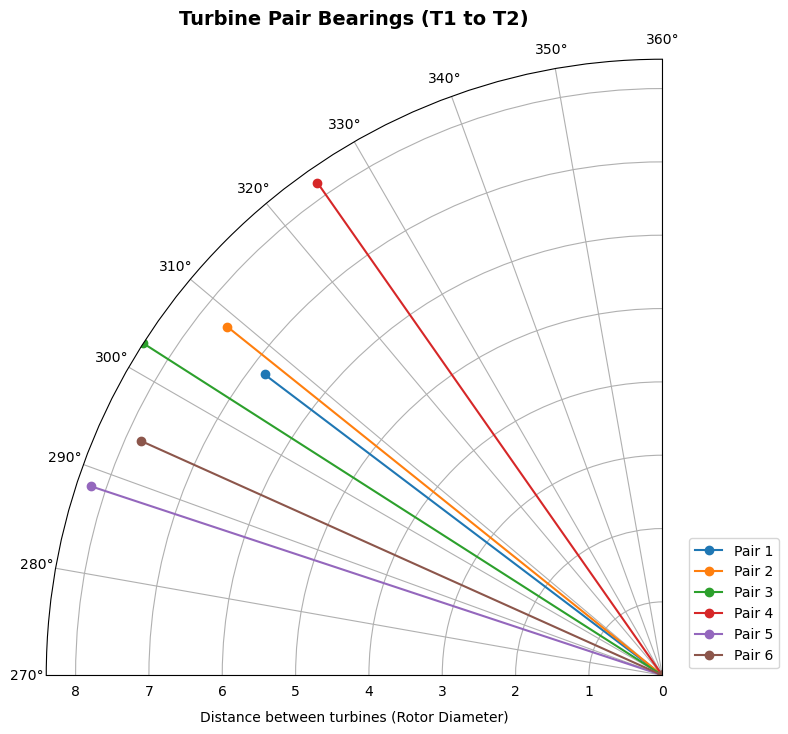

In [5]:
# Sample data for 6 turbine pairs
bearing_angles = [307.1, 308.7, 302.6, 325.0, 288.3, 294.2]
distances = [6.8, 7.6, 8.4, 8.2, 8.2, 7.8] 
turbine_pairs = ['Pair 1', 'Pair 2', 'Pair 3', 'Pair 4', 'Pair 5', 'Pair 6']

# Convert bearing angles to radians
bearing_radians = np.deg2rad(bearing_angles)

# Plot polar coordinates
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location('N')

# Plot each turbine pair with a dot at the end of the line
for i in range(len(bearing_radians)):
    ax.plot([bearing_radians[i], bearing_radians[i]], [0, distances[i]], marker='o', label=turbine_pairs[i])

# Set theta limits to focus on the 270-360 angle section
ax.set_ylim(0, max(distances))
ax.set_xlim(np.deg2rad(270), np.deg2rad(360))  # Restrict to the 270-360 (0) angle
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2)  # Shift

# Add legend
plt.legend(loc='lower right', bbox_to_anchor=(1.2, 0))

# Show plot
plt.title('Turbine Pair Bearings (T1 to T2)', fontweight='bold', fontsize=14, pad=25)
plt.xlabel("Distance between turbines (Rotor Diameter)", labelpad=20)
plt.show()

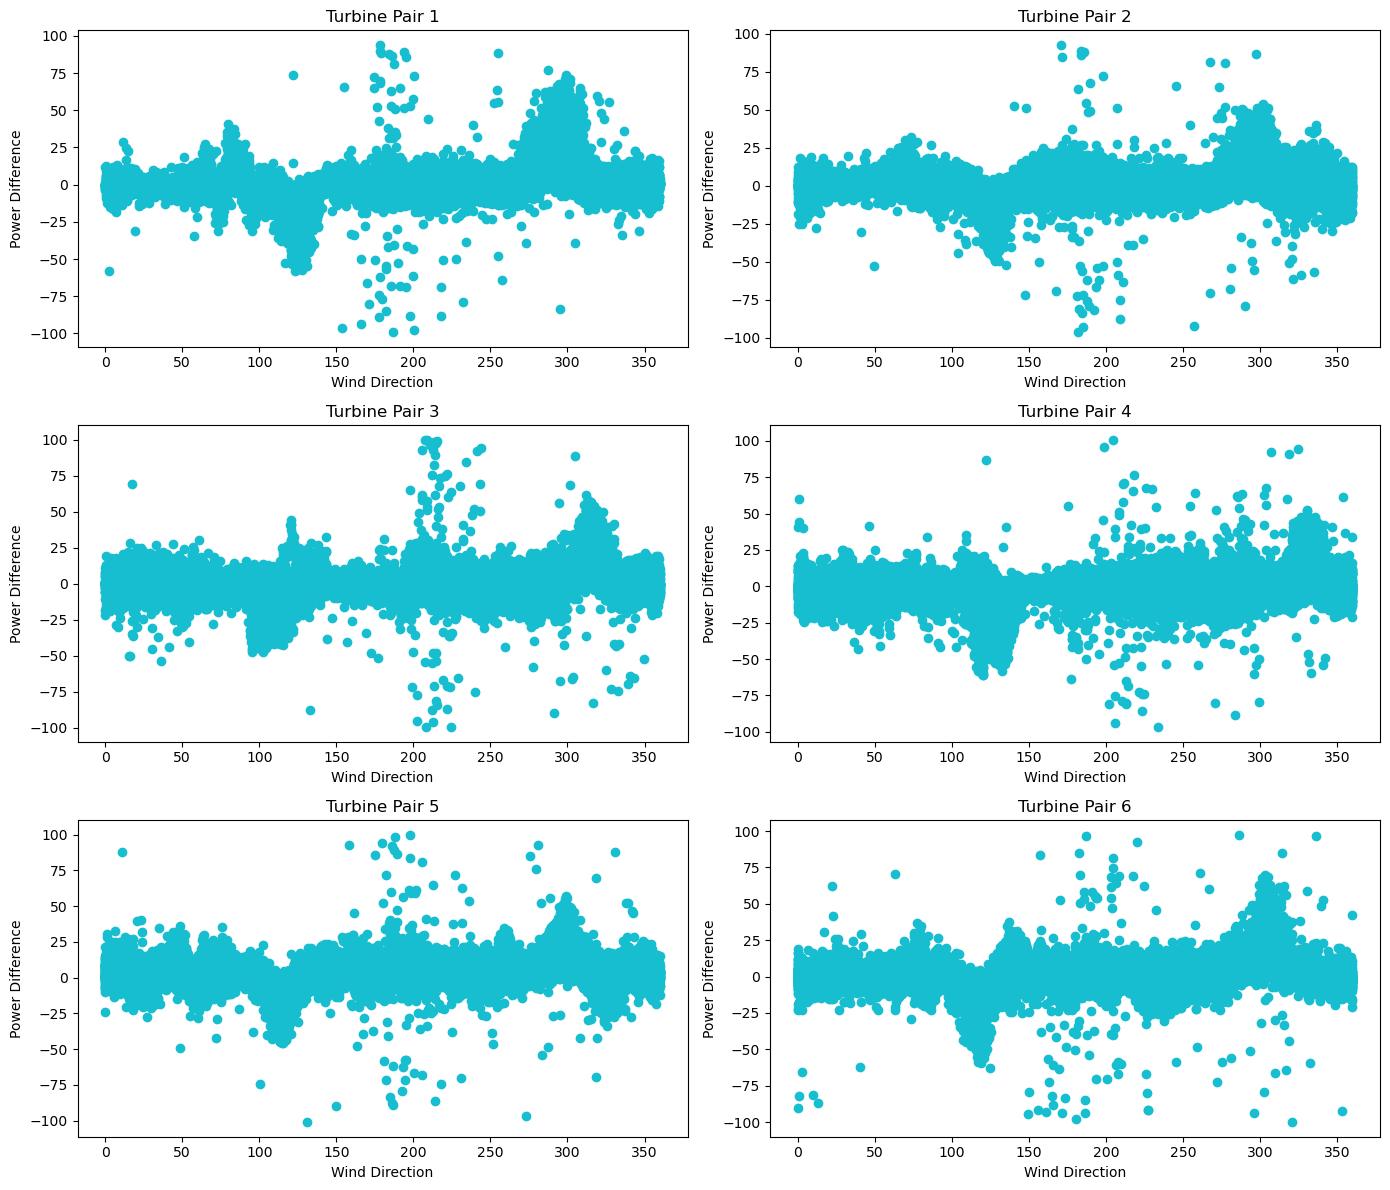

<Figure size 800x600 with 0 Axes>

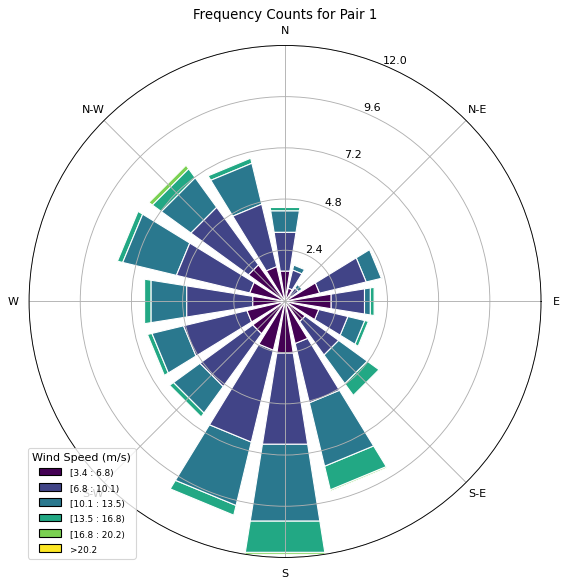

<Figure size 800x600 with 0 Axes>

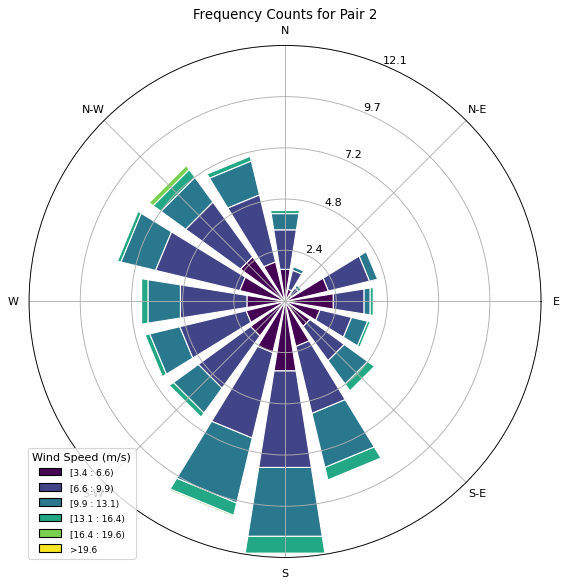

<Figure size 800x600 with 0 Axes>

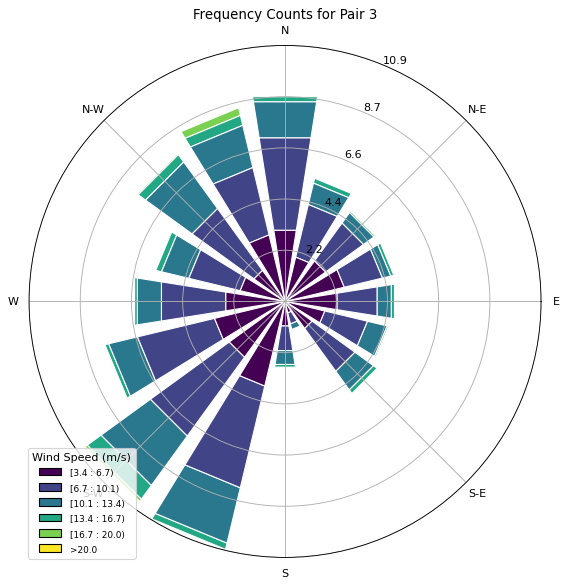

<Figure size 800x600 with 0 Axes>

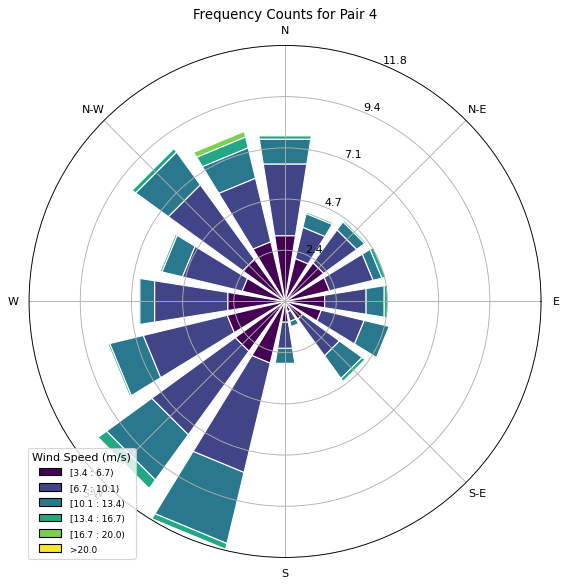

<Figure size 800x600 with 0 Axes>

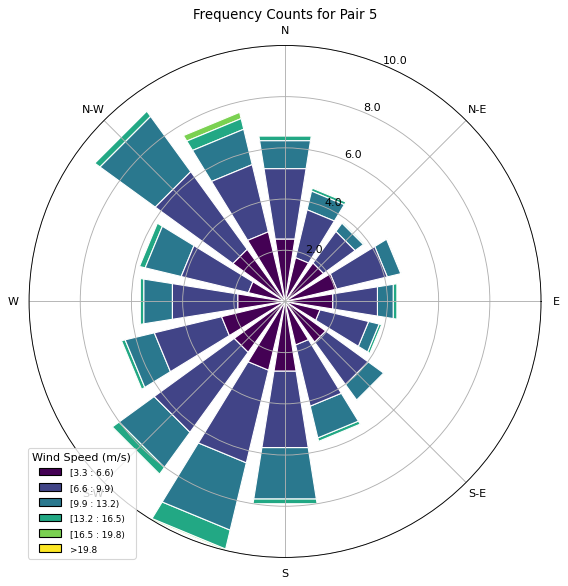

<Figure size 800x600 with 0 Axes>

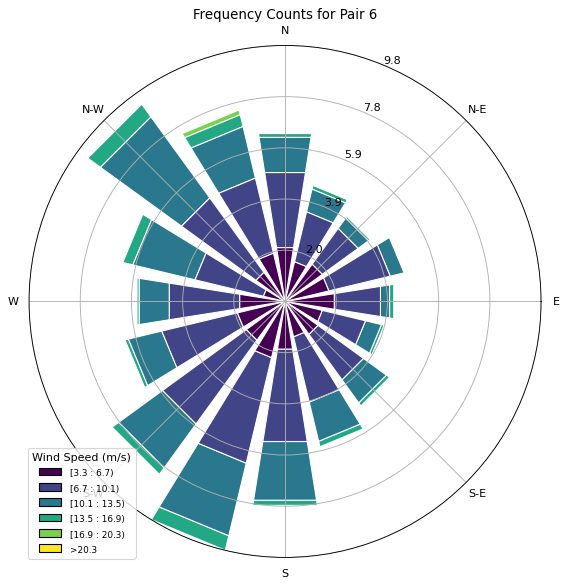

In [6]:
from windrose import WindroseAxes
# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Plot power difference vs. wind direction for each pair on separate subplots
for i, data in zip(range(6), ldata):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    ax.scatter(data['D'], data['PWdiff'], color='tab:cyan')
    ax.set_xlabel('Wind Direction')
    ax.set_ylabel('Power Difference')
    ax.set_title(f'Turbine Pair {i+1}')

# Adjust layout
plt.tight_layout()
plt.show()
plt.close()

# Plot wind rose for each pair
for i, data in zip(range(6), ldata):
    fig = plt.figure(figsize=(8, 6))
    ax = WindroseAxes.from_ax()
    ax.bar(data['D'], data['Va'], normed=True, opening=0.8, edgecolor='white')
    ax.set_legend(title='Wind Speed (m/s)')
    ax.set_title(f'Frequency Counts for Pair {i+1}')
    plt.show()
    plt.close(fig)

## 2. Modelling

In [141]:
from sklearn.model_selection import train_test_split

np.random.seed(20)

# Split dataset into training and testing (5000 most recent samples).
# Independent (X) predictors
features = ['Va', 'D', 'V_diff','V1','V2', 'PW1']
X = ldata[0][features].values[-5000:]
# Dependent (Y) target definition
y = ldata[0]['PW2'].values[-5000:]
# Train-Test Split (10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)

### 2.1 Artificial Neural Network

#### 2.1.1 Baseline ANN model

16/16 [==============================] - 0s 1ms/step


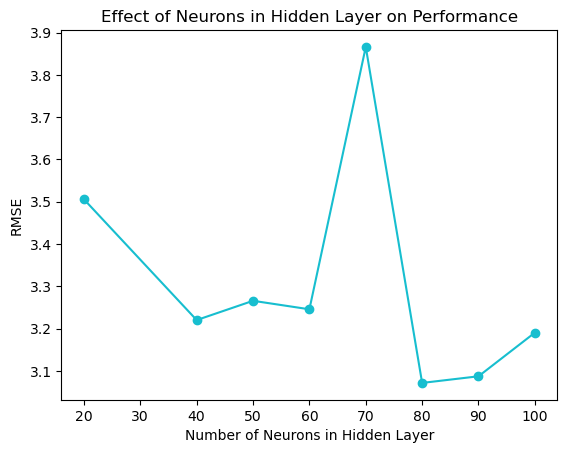

In [24]:
# Define a range of neurons to experiment with
neurons_range = [20, 40, 50, 60, 70, 80, 90, 100]

# Create a list to store RMSE for each model
rmse_values = []

# Create and train models with different numbers of neurons
for neurons in neurons_range:
    model = create_baseANN_model(X_train, y_train, neurons=neurons, epoch=100)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)

# Plot graph to visualize the effect of adding more neurons on performance
plt.plot(neurons_range, rmse_values, marker='o', color='tab:cyan')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('RMSE')
plt.title('Effect of Neurons in Hidden Layer on Performance')
plt.show()

16/16 [==============================] - 0s 1ms/step


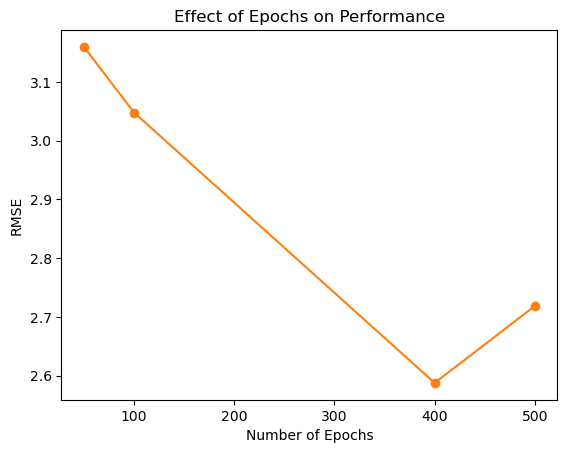

In [30]:
# Define a range of epochs to experiment with
epochs_range = [50, 100, 400, 500]
# Create a list to store RMSE for each model
rmse_values = []

# Create and train models with different numbers of epochs
for epochs in epochs_range:
    model = create_baseANN_model(X_train, y_train, epoch=epochs, neurons=80)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)

# Plot graph to visualize the effect of adding more epochs on performance
plt.plot(epochs_range, rmse_values, marker='o', color='tab:orange')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.title('Effect of Epochs on Performance')
plt.show()

#### 2.1.2 Deep ANN model

16/16 [==============================] - 0s 2ms/step


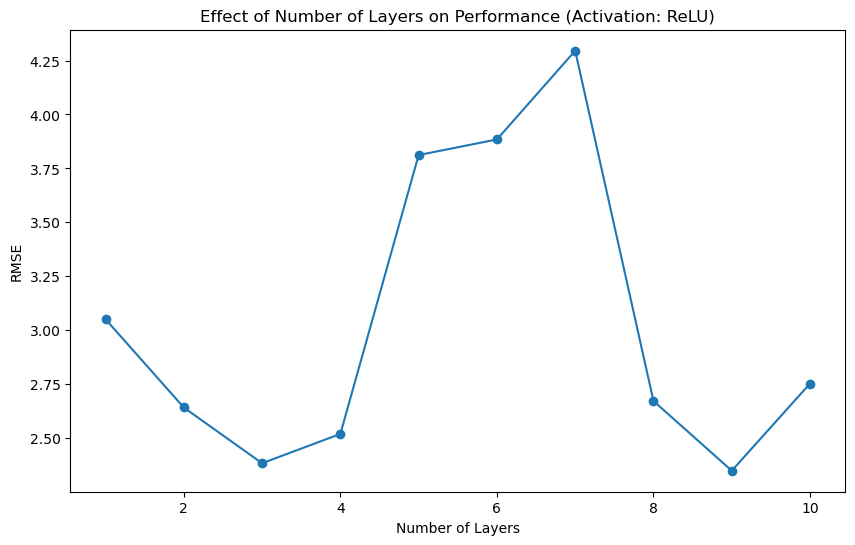

In [31]:
# Define configurations for experimentation
num_layers_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Train and evaluate deep NN models for different configurations
results = []
for num_layers in num_layers_list:
    model = create_deep_model(X_train, y_train, neurons=80, num_layers=num_layers)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    results.append((num_layers, rmse))

# Plot line graph to visualize the effect of adding more layers on performance
plt.figure(figsize=(10, 6))
plt.plot([result[0] for result in results], [result[1] for result in results], marker='o')
plt.xlabel('Number of Layers')
plt.ylabel('RMSE')
plt.title('Effect of Number of Layers on Performance (Activation: ReLU)')
plt.show()

16/16 [==============================] - 0s 2ms/step


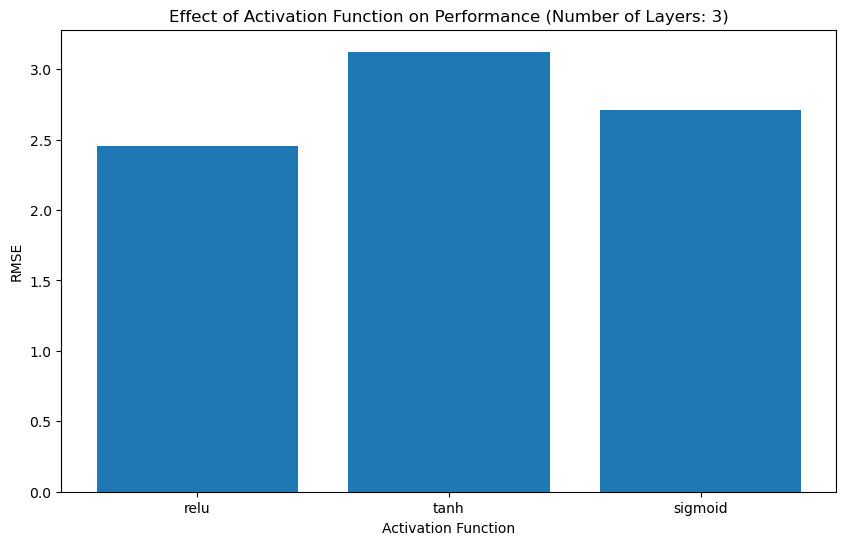

In [20]:
# Define configurations for experimentation
activations = ['relu', 'tanh', 'sigmoid']

# Train and evaluate deep NN models for different activation functions
results_activation = []
for activation in activations:
    model  = create_deep_model(X_train, y_train, activ=activation)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    results_activation.append((activation, rmse))

# Plot bar plot to compare the impact of different activation functions on performance
plt.figure(figsize=(10, 6))
plt.bar([result[0] for result in results_activation], [result[1] for result in results_activation])
plt.xlabel('Activation Function')
plt.ylabel('RMSE')
plt.title('Effect of Activation Function on Performance (Number of Layers: 3)')
plt.show()

In [155]:
np.random.seed(20)

pair_rmse_deep = []

for i in range(len(ldata)):
    # Drop NaN rows
    data = ldata[i]
    data = data.dropna()
    
    # Independent (X) predictors
    features = ['Va', 'D', 'V_diff','V1','V2', 'PW1']
    X = ldata[0][features].values[-5000:]
    # Dependent (Y) target definition
    y = ldata[0]['PW2'].values[-5000:]
    # Train-Test Split (10% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)
    
    deep_model = create_deep_model(X_train, y_train)
    y_pred = deep_model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE: {rmse}')
    pair_rmse_deep.append(rmse)
    

16/16 [==============================] - 0s 2ms/step
RMSE: 2.3947026848085606
16/16 [==============================] - 0s 2ms/step
RMSE: 2.4213737134926174
16/16 [==============================] - 0s 1ms/step
RMSE: 2.399526943513661
16/16 [==============================] - 0s 2ms/step
RMSE: 2.4179986877774913
16/16 [==============================] - 0s 2ms/step
RMSE: 2.6163317208502055
16/16 [==============================] - 0s 2ms/step
RMSE: 3.000970669576817


### 2.2 CNN (Convolution Neural Network)

In [136]:
np.random.seed(20)

pair_rmse_cnn = []

for i in range(len(ldata)):
    # Drop NaN rows
    data = ldata[i]
    data = data.dropna()

    # Independent (X) predictors
    features = ['Va', 'D', 'V_diff','V1','V2', 'PW1']
    X = data[features].values[-5000:]
    # Dependent (Y) target definition
    y = data['PW2'].values[-5000:]
    # Train-Test Split (10% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)
    
    # Reshape the data for 1D CNN
    X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Specify hyperparameters
    filters1 = 32
    kernel_size1 = 3
    filters2 = 64
    kernel_size2 = 3
    units = 128
    num_layers = 3
    num_conv_layers = 4


    # Create the CNN model
    cnn_model = create_cnn_model(X_train_cnn, filters1=filters1, kernel_size1=kernel_size1, filters2=filters2, kernel_size2=kernel_size2, units=units, num_layers=num_layers, num_conv_layers=num_conv_layers)

    # Train the model
    history = cnn_model.fit(X_train_cnn, y_train, epochs=400, batch_size=32, validation_split=0.1, verbose=0)

    # Evaluate the model
    y_pred = cnn_model.predict(X_test_cnn)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse}")
    
    pair_rmse_cnn.append(rmse)

16/16 [==============================] - 0s 2ms/step
RMSE: 2.150105762447548
16/16 [==============================] - 0s 2ms/step
RMSE: 3.179101512018645
16/16 [==============================] - 0s 2ms/step
RMSE: 2.3354991624122374
16/16 [==============================] - 0s 2ms/step
RMSE: 2.435671948463332
16/16 [==============================] - 0s 2ms/step
RMSE: 1.9568441249527855
16/16 [==============================] - 0s 2ms/step
RMSE: 2.555030726646543


In [111]:
hyperparameter_rmse = []
# Testing out different combination of hyperparameters
# Define hyperparameter groups
hyperparameter_groups = [
    {'filters1': 32, 'kernel_size1': 3, 'filters2': 64, 'kernel_size2': 3, 'units': 128, 'num_layers': 3, 'num_conv_layers': 4},
    {'filters1': 64, 'kernel_size1': 5, 'filters2': 128, 'kernel_size2': 5, 'units': 256, 'num_layers': 3, 'num_conv_layers': 4},
    {'filters1': 64, 'kernel_size1': 5, 'filters2': 128, 'kernel_size2': 3, 'units': 128, 'num_layers': 3, 'num_conv_layers': 3}
]

# Loop through each hyperparameter group
for idx, hyperparameters in enumerate(hyperparameter_groups, start=1):
    # Create the CNN model
    cnn_model = create_cnn_model(X_train_cnn, **hyperparameters)

    # Train the model
    history = cnn_model.fit(X_train_cnn, y_train, epochs=400, batch_size=32, validation_split=0.1, verbose=0)

    # Evaluate the model
    y_pred = cnn_model.predict(X_test_cnn)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"Hyperparameter Group {idx}: {hyperparameters}, RMSE: {rmse}")
    hyperparameter_rmse.append((idx, rmse))

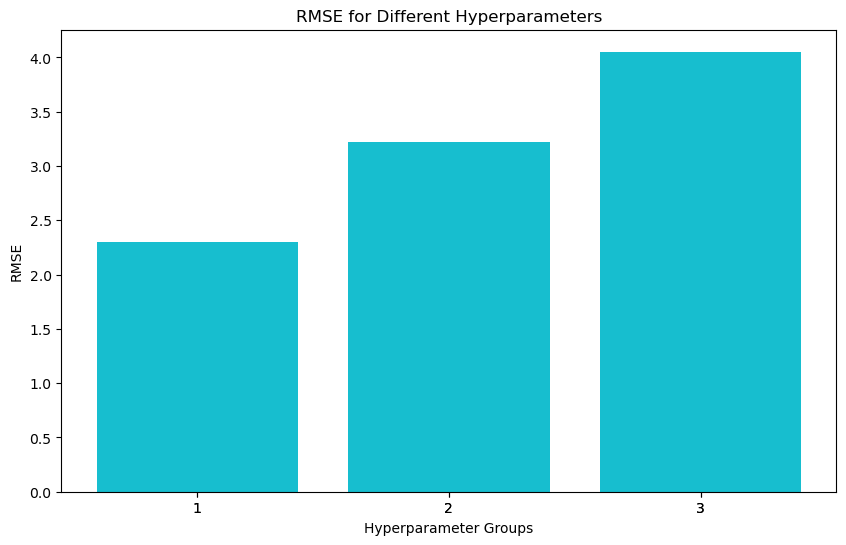

In [123]:
# Plotting RMSE against different hyperparameter groups
# Extracting groups and rmse values
ids = [x[0] for x in hyperparameter_rmse]
rmse_values = [x[1] for x in hyperparameter_rmse]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(ids, rmse_values, color='tab:cyan')
plt.xlabel('Hyperparameter Groups')
plt.ylabel('RMSE')
plt.title('RMSE for Different Hyperparameters')
plt.xticks(ids)
plt.show()

### 2.3 LSTM (Long Short-Term Memory)

In [161]:
np.random.seed(20)

pair_rmse_lstm = []

for i in range(len(ldata)):
    # Drop NaN rows
    data = ldata[i]
    data = data.dropna()

    # Independent (X) predictors
    features = ['Va', 'D', 'V_diff','V1','V2', 'PW1']
    X = data[features].values[-5000:]
    # Dependent (Y) target definition
    y = data['PW2'].values[-5000:]
    # Train-Test Split (10% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)
    
    # Reshape the data for LSTM
    X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    # Specify hyperparameters
    units = 128
    num_layers = 2
    num_lstm_layers = 2


    # Create the CNN model
    lstm_model = create_lstm_model(X_train_lstm, units=units, num_layers=num_layers, num_lstm_layers=num_lstm_layers)

    # Train the model
    history = lstm_model.fit(X_train_lstm, y_train, epochs=400, batch_size=32, validation_split=0.1, verbose=0)

    # Evaluate the model
    y_pred = lstm_model.predict(X_test_lstm)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse}")
    
    pair_rmse_lstm.append(rmse)

16/16 [==============================] - 0s 4ms/step
RMSE: 2.352856465203375
16/16 [==============================] - 0s 3ms/step
RMSE: 3.198468244781521
16/16 [==============================] - 0s 4ms/step
RMSE: 2.2210993533338863
16/16 [==============================] - 0s 3ms/step
RMSE: 2.2657918246457287
16/16 [==============================] - 0s 3ms/step
RMSE: 2.9040216250333897
16/16 [==============================] - 0s 3ms/step
RMSE: 2.601447913653237


### 2.4 Random Forest Regressor

In [159]:
from sklearn.ensemble import RandomForestRegressor

np.random.seed(20)

pair_rmse_rf = []

for i in range(len(ldata)):
    # Drop NaN rows
    data = ldata[i]
    data = data.dropna()

    # Independent (X) predictors
    features = ['Va', 'D', 'V_diff','V1','V2', 'PW1']
    X = data[features].values[-5000:]
    # Dependent (Y) target definition
    y = data['PW2'].values[-5000:]
    # Train-Test Split (10% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)

    # Initialize and train the model
    model = RandomForestRegressor(random_state=7)
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse}")

    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"MAPE: {mape}")
    
    pair_rmse_rf.append(rmse)

RMSE: 2.6961186055470847
MAPE: 0.1784049043155519
RMSE: 3.1254923557699077
MAPE: 0.17238934366313652
RMSE: 2.37654196100449
MAPE: 0.12340728198364379
RMSE: 3.532932049784301
MAPE: 0.374233561312266
RMSE: 2.5107677944620783
MAPE: 0.1589098759502059
RMSE: 2.3808251782591063
MAPE: 0.13002581035310437
